In [14]:
import numpy as np
import keras
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Utils Functions ===
def dm2comp(dm):
    '''Extract weights and vectors from a density matrix.'''
    return dm[:, :, 0], dm[:, :, 1:]

def pure2dm(psi):
    '''Construct a pure-state density matrix from feature vectors.'''
    ones = keras.ops.ones_like(psi[:, 0:1])
    dm = keras.ops.concatenate((ones[:, np.newaxis, :], psi[:, np.newaxis, :]), axis=2)
    return dm

def dm_rbf_loglik(x, dm, sigma):
    '''Log-likelihood under an RBF-kernel density matrix.'''
    d = keras.ops.shape(x)[-1]
    w, v = dm2comp(dm)
    dist = keras.ops.sum((x[:, np.newaxis, :] - v) ** 2, axis=-1)
    ll = keras.ops.log(
        keras.ops.einsum('...i,...i->...',
                        w,
                        keras.ops.exp(-dist / (2 * sigma ** 2)) ** 2)
        + 1e-12)
    coeff = d * keras.ops.log(sigma + 1e-12) + d * np.log(np.pi) / 2
    return ll - coeff

def dm_rbf_expectation(dm):
    '''Expectation under an RBF-kernel density matrix.'''
    w, v = dm2comp(dm)
    return keras.ops.einsum('...i,...ij->...j', w, v)

def dm_rbf_variance(dm, sigma):
    '''Variance (trace) under an RBF-kernel density matrix.'''
    sigma_adj = sigma / keras.ops.sqrt(2)
    w, v = dm2comp(dm)
    d = keras.ops.shape(v)[-1]
    squared_norms = keras.ops.sum(v ** 2, axis=-1)
    weighted_sq = keras.ops.einsum('...i,...i->...', w, squared_norms)
    means = keras.ops.einsum('...i,...ij->...j', w, v)
    sq_means = keras.ops.sum(means ** 2, axis=-1)
    between = weighted_sq - sq_means
    return between + d * (sigma_adj ** 2)

def gauss_entropy_lb(d, sigma):
    '''Lower bound on entropy of a Gaussian mixture.'''
    return (d / 2.0) * (1.0 + keras.ops.log(2.0 * np.pi * (sigma ** 2)))

def l1_loss(vals):
    '''L1 regularization over normalized activations or components.'''
    b_size = keras.ops.cast(keras.ops.shape(vals)[0], dtype=keras.float32)
    vals_norm = keras.utils.normalize(vals, order=2, axis=1)
    return keras.ops.sum(keras.ops.abs(vals_norm)) / b_size

In [15]:
# === Kernel Layers ===
class RBFKernelLayer(keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = self.add_weight(shape=(), initializer=keras.initializers.Constant(value=sigma), trainable=trainable)
        self.dim = dim
        self.min_sigma = min_sigma
    def call(self, A, B):
        shape_A = keras.ops.shape(A)
        shape_B = keras.ops.shape(B)
        A_norm = keras.ops.sum(A**2, axis=-1)[..., np.newaxis]
        B_norm = keras.ops.sum(B**2, axis=-1)[np.newaxis, np.newaxis, :]
        A_flat = keras.ops.reshape(A, [-1, shape_A[2]])
        AB = keras.ops.matmul(A_flat, keras.ops.transpose(B))
        AB = keras.ops.reshape(AB, [shape_A[0], shape_A[1], shape_B[0]])
        dist2 = keras.ops.clip(A_norm + B_norm - 2.*AB, 0., np.inf)
        self.sigma.assign(keras.ops.clip(self.sigma, self.min_sigma, np.inf))
        return keras.ops.exp(-dist2/(2.*self.sigma**2))
    def log_weight(self):
        sigma_c = keras.ops.clip(self.sigma, self.min_sigma, np.inf)
        return -self.dim*keras.ops.log(sigma_c+1e-12) - self.dim*np.log(4*np.pi)

class KDMLayer(keras.layers.Layer):
    def __init__(self, kernel, dim_x, dim_y, x_train=True, y_train=True, w_train=True, n_comp=0, l1_x=0., l1_y=0., l1_act=0., generative=0., **kwargs):
        super().__init__(**kwargs)
        self.kernel, self.dim_x, self.dim_y = kernel, dim_x, dim_y
        self.x_train, self.y_train, self.w_train = x_train, y_train, w_train
        self.n_comp, self.l1_x, self.l1_y, self.l1_act, self.generative = n_comp, l1_x, l1_y, l1_act, generative
        self.c_x = self.add_weight(shape=(n_comp, dim_x), initializer=keras.initializers.random_normal(), trainable=x_train, name="c_x")
        self.c_y = self.add_weight(shape=(n_comp, dim_y), initializer=keras.initializers.Constant(np.sqrt(1./dim_y)), trainable=y_train, name="c_y")
        self.c_w = self.add_weight(shape=(n_comp,), initializer=keras.initializers.constant(1./n_comp), trainable=w_train, name="c_w")
        self.eps = 1e-12
    def call(self, inputs):
        if self.l1_x: self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y: self.add_loss(self.l1_y * l1_loss(self.c_y))
        cw = keras.ops.abs(self.c_w); cw_sum = keras.ops.clip(keras.ops.sum(cw), self.eps, np.inf)
        self.c_w.assign(cw/cw_sum)
        in_w = inputs[...,0]; in_v = inputs[...,1:]
        out_vw = self.kernel(in_v, self.c_x)
        out_w = cw[np.newaxis,np.newaxis,:]*keras.ops.square(out_vw)
        if self.generative:
            proj = keras.ops.einsum('...i,...ij->...', in_w, out_w)
            logp = keras.ops.log(proj+self.eps) + self.kernel.log_weight()
            self.add_loss(-self.generative*keras.ops.mean(logp))
        out_w = keras.ops.maximum(out_w, self.eps)
        out_w = out_w/keras.ops.sum(out_w,axis=2,keepdims=True)
        out_w = keras.ops.einsum('...i,...ij->...j', in_w, out_w)
        if self.l1_act: self.add_loss(self.l1_act*l1_loss(out_w))
        out_w = out_w[...,np.newaxis]
        b = keras.ops.shape(out_w)[0]
        out_y = keras.ops.broadcast_to(self.c_y[np.newaxis,...],[b,self.n_comp,self.dim_y])
        return keras.ops.concatenate((out_w,out_y),axis=2)
    def get_config(self): return {**super().get_config(), 'dim_x':self.dim_x,'dim_y':self.dim_y,'n_comp':self.n_comp}

class KDMRegressModel(keras.Model):
    def __init__(self, encoded_size, dim_y, encoder, n_comp, sigma_x=0.1, min_sigma_x=1e-3, sigma_y=0.1, min_sigma_y=1e-3, x_train=True, y_train=True, w_train=True, generative=0., entropy_reg_x=0., sigma_x_trainable=True, sigma_y_trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.encoder, self.entropy_reg_x = encoder, entropy_reg_x
        self.dim_y, self.encoded_size, self.n_comp = dim_y, encoded_size, n_comp
        if generative>0: encoder.trainable=False
        self.kernel = RBFKernelLayer(sigma_x, encoded_size, sigma_x_trainable, min_sigma_x)
        self.kdm = KDMLayer(self.kernel, encoded_size, dim_y, x_train, y_train, w_train, n_comp, generative=generative)
        self.sigma_y = self.add_weight(shape=(), initializer=keras.initializers.constant(sigma_y), trainable=sigma_y_trainable)
        self.min_sigma_y = min_sigma_y
    def call(self, x):
        rho_x = pure2dm(self.encoder(x))
        rho_y = self.kdm(rho_x)
        self.sigma_y.assign(keras.ops.clip(self.sigma_y,self.min_sigma_y,np.inf))
        return rho_y
    def predict_reg(self,x,**kw): rho= self.predict(x,**kw); return keras.ops.convert_to_numpy(dm_rbf_expectation(rho)), keras.ops.convert_to_numpy(dm_rbf_variance(rho,self.sigma_y))
    def get_sigmas(self): return keras.ops.convert_to_numpy(self.kernel.sigma), keras.ops.convert_to_numpy(self.sigma_y)
    def init_components(self, sx, sy, init_sigma=False, sigma_mult=1):
        enc = self.encoder.predict(sx)
        if init_sigma:
            d,_ = NearestNeighbors(3).fit(keras.ops.convert_to_numpy(enc)).kneighbors(keras.ops.convert_to_numpy(enc))
            self.kernel.sigma.assign(d[:,2].mean()*sigma_mult)
        self.kdm.c_x.assign(enc); self.kdm.c_y.assign(sy); self.kdm.c_w.assign(keras.ops.ones((self.n_comp,))/self.n_comp)
    def loglik(self,y,t): return -keras.ops.mean(dm_rbf_loglik(y,t,self.sigma_y))
    def compute_loss(self,x,y,pw,sw,training=True):
        loss=self.loglik(y,pw)
        if self.losses: loss+=keras.ops.sum(self.losses)
        if self.entropy_reg_x: loss-=self.entropy_reg_x*gauss_entropy_lb(self.encoded_size,self.kernel.sigma/keras.ops.sqrt(2))
        return loss


In [16]:
!pip install ucimlrepo
# === Data Loading and Preparation ===
from ucimlrepo import fetch_ucirepo
# Load Combined Cycle Power Plant dataset
ccpp = fetch_ucirepo(id=294)
X = ccpp.data.features.values; y = ccpp.data.targets.values.reshape(-1,1)
X = StandardScaler().fit_transform(X); y = StandardScaler().fit_transform(y)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


In [17]:
# === Model Setup ===
enc = keras.Sequential([keras.layers.Identity()]); n_comp=50
model = KDMRegressModel(x_train.shape[1], y_train.shape[1], enc, n_comp,
                        sigma_x=0.2, min_sigma_x=1e-3, sigma_y=0.3, min_sigma_y=0.15,
                        generative=1.0, sigma_x_trainable=False)
model.compile(optimizer=optimizers.Adam(5e-3))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
idx = np.random.RandomState(42).randint(x_train.shape[0], size=n_comp)
model.init_components(x_train[idx], y_train[idx], init_sigma=False)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=32, callbacks=[early_stop], verbose=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 17.6061 - val_loss: 16.7568
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 16.0761 - val_loss: 16.3959
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.6074 - val_loss: 16.1096
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.3643 - val_loss: 16.0270
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.2859 - val_loss: 16.0817
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.3065 - val_loss: 16.0883
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 15.2273 - val_loss: 16.0920
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2732 - val_loss: 16.0860
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.2047 - val_loss: 16.0804


In [23]:
# === Sigmas ===
sx, sy = model.get_sigmas(); print(f"sigma_x={sx:.4f}, sigma_y={sy:.4f}")

# === Predictions ===
y_pred, y_var = model.predict_reg(x_test)
# Rescale
# Use .values to get the underlying NumPy array from the DataFrame
sc_y = StandardScaler().fit(ccpp.data.targets.values.reshape(-1,1))
y_pred_res = sc_y.inverse_transform(y_pred); y_test_res = sc_y.inverse_transform(y_test)

sigma_x=0.2000, sigma_y=0.4044
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


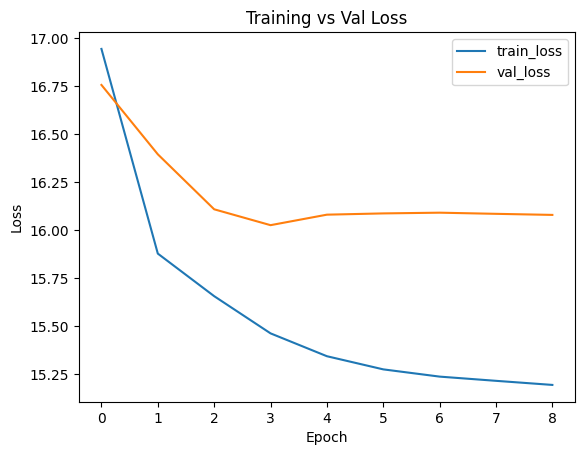

In [24]:
# Loss curves
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Val Loss'); plt.legend(); plt.show()


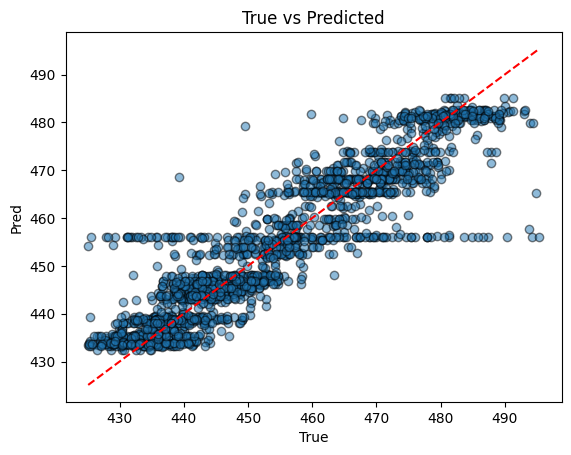

In [25]:
# True vs Predicted
plt.figure()
plt.scatter(y_test_res, y_pred_res, alpha=0.5, edgecolor='k')
lims=[y_test_res.min(), y_test_res.max()]
plt.plot(lims, lims, 'r--'); plt.xlabel('True'); plt.ylabel('Pred'); plt.title('True vs Predicted'); plt.show()


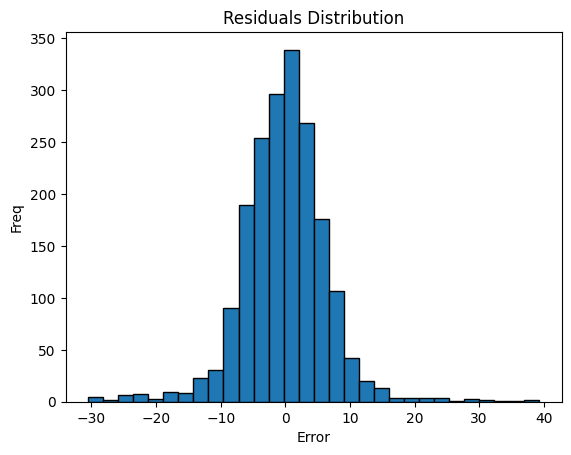

In [26]:
# Residuals histogram
res = y_test_res - y_pred_res
plt.figure()
plt.hist(res.flatten(), bins=30, edgecolor='k')
plt.title('Residuals Distribution'); plt.xlabel('Error'); plt.ylabel('Freq'); plt.show()


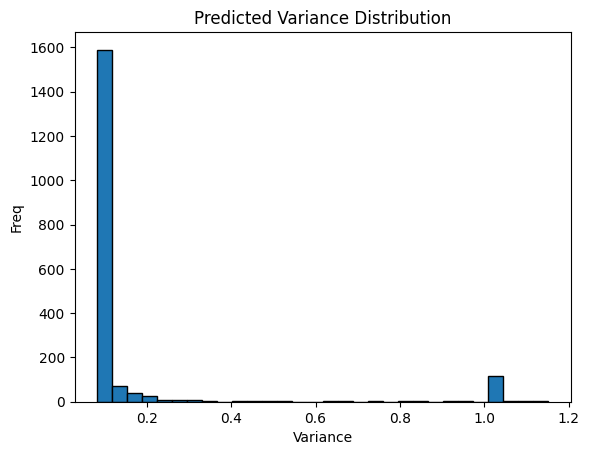

In [27]:
# Predicted variance histogram
plt.figure()
plt.hist(y_var.flatten(), bins=30, edgecolor='k')
plt.title('Predicted Variance Distribution'); plt.xlabel('Variance'); plt.ylabel('Freq'); plt.show()


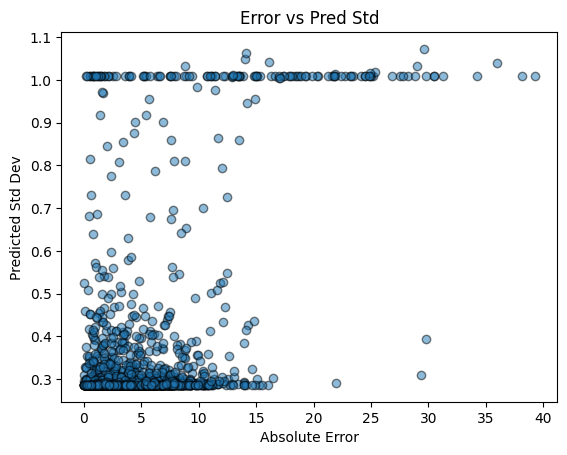

In [28]:
# Error vs Pred Std Dev
plt.figure()
plt.scatter(np.abs(res.flatten()), np.sqrt(y_var.flatten()), alpha=0.5, edgecolor='k')
plt.xlabel('Absolute Error'); plt.ylabel('Predicted Std Dev'); plt.title('Error vs Pred Std'); plt.show()


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# --- Cálculo de métricas ---
# y_test_res y y_pred_res deben estar ya reescalados a las unidades originales
mse = mean_squared_error(y_test_res, y_pred_res)
r2 = r2_score(y_test_res, y_pred_res)

# --- Sigmas aprendidos ---
sigma_x, sigma_y = model.get_sigmas()

# --- Impresión de resultados ---
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Sigma_x aprendido: {sigma_x:.4f}")
print(f"Sigma_y aprendido: {sigma_y:.4f}")


Test MSE: 45.0260
Test R²: 0.8448
Sigma_x aprendido: 0.2000
Sigma_y aprendido: 0.4044
